# Imports

In [14]:
%%capture
import torch
import matplotlib.pyplot as plt
import torchvision
import numpy as np
from torch.utils.data import Subset, DataLoader
from random import shuffle
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

if not torch.cuda.is_available():
    raise SystemError("GPU device not found, selection Runtime -> Change runtime type")

# Hyper Parameters

We use this cell to define all the hyperparameter needed for our work

In [15]:

args = {
    'lr_classifier':1e-3,
    'batch_size': 128,
    'epochs': 10,
    'num_epochs_gan': 12,
    'num_tasks': 5,
    'dataset': 'MNIST',
    'num_classes': 10,
    'in_size': 28,
    'n_channels': 1,
    'hidden_size': 64,
    'lr_generator': 3e-4,
    'lr_discriminator': 3e-4,
    'latent_dim':128,
    }

results = {
    'Generator loss' : [],
    'Discriminator loss' : [],
    'Loss': [],
    'Accuracy' : []
    }

# Useful functions from your notebooks

In [16]:
def get_dataset(dataroot, dataset):
    if dataset == 'MNIST':
        mean, std = (0.1307), (0.3081)

    transform = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(mean=mean, std=std)])

    train_dataset = torchvision.datasets.__dict__[dataset](
        root=dataroot,
        train=True,
        download=True,
        transform=transform
    )

    val_dataset = torchvision.datasets.__dict__[dataset](
        root=dataroot,
        train=False,
        download=True,
        transform=transform
    )

    return train_dataset, val_dataset

def split_dataset(dataset, tasks_split):
    split_dataset = {}
    for e, current_classes in tasks_split.items():
        task_indices = np.isin(np.array(dataset.targets), current_classes)
        split_dataset[e] = Subset(dataset, np.where(task_indices)[0])
    return split_dataset

def dict2array(acc):
    num_tasks = len(acc)
    first_task = list(acc.keys())[0]
    sequence_length = len(acc[first_task]) if isinstance(acc[first_task], list) else num_tasks
    acc_array = np.zeros((num_tasks, sequence_length))
    for task, val in acc.items():
        acc_array[int(task), :] = val
    return acc_array

def plot_accuracy_matrix(array):
    num_tasks = array.shape[1]
    array = np.round(array, 2)
    fig, ax = plt.subplots()
    ax.imshow(array, vmin=np.min(array), vmax=np.max(array))
    for i in range(len(array)):
        for j in range(array.shape[1]):
            ax.text(j,i, array[i,j], va='center', ha='center', c='w', fontsize=15)
    ax.set_yticks(np.arange(num_tasks))
    ax.set_ylabel('Number of tasks')
    ax.set_xticks(np.arange(num_tasks))
    ax.set_xlabel('Tasks finished')
    ax.set_title(f"ACC: {np.mean(array[:, -1]):.3f} -- std {np.std(np.mean(array[:, -1])):.3f}")
    plt.savefig('matrix.pdf', dpi=600)
    plt.show()

def plot_acc_over_time(array):
    fig, ax = plt.subplots()
    for e, acc in enumerate(array):
        ax.plot(acc, label=f"Task {e}")
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.savefig('over_time.pdf', dpi=600)
    plt.show()

def compute_average_accuracy(array):
    num_tasks = len(array)
    avg_acc = np.sum(array[:, -1], axis=0)/num_tasks
    return avg_acc

def compute_backward_transfer(array):
    num_tasks = len(array)
    diag = np.diag(array)[:-1] # Note, we do not compute backward transfer for the last task!
    end_acc = array[:-1, -1]
    bwt = np.sum(end_acc - diag)/(num_tasks - 1)
    return bwt

def compute_forward_transfer(array, b):
    num_tasks = len(array)
    sub_diag = np.diag(array, k=-1) # Note, we do not compute forward transfer for the first task!
    fwt = np.sum(sub_diag - b[1:])/(num_tasks - 1)
    return fwt

# Models

## GAN

In [17]:
class Generator(torch.nn.Module):
    def __init__(self,
                 latent_dim,
                 img_shape):
        super(Generator, self).__init__()
        self.img_shape = img_shape

        self.model = torch.nn.Sequential(
            torch.nn.Linear(latent_dim, 128),
            torch.nn.LeakyReLU(0.2),
            torch.nn.Linear(128, 256),
            torch.nn.BatchNorm1d(256, 0.8),
            torch.nn.LeakyReLU(0.2),
            torch.nn.Linear(256, 512),
            torch.nn.BatchNorm1d(512, 0.8),
            torch.nn.LeakyReLU(0.2),
            torch.nn.Linear(512, int(np.prod(img_shape))),
            torch.nn.Tanh()
        )

    def forward(self, z):
        img_fake = self.model(z)
        img_fake = img_fake.view(img_fake.size(0), *self.img_shape)
        return img_fake

class Discriminator(torch.nn.Module):
    def __init__(self,
                 img_shape):
        super(Discriminator, self).__init__()

        self.model = torch.nn.Sequential(
            torch.nn.Linear(int(np.prod(img_shape)), 512),
            torch.nn.LeakyReLU(0.2),
            torch.nn.Linear(512, 256),
            torch.nn.LeakyReLU(0.2),
            torch.nn.Linear(256, 128),
            torch.nn.LeakyReLU(0.2),
            torch.nn.Linear(128, 1),
            torch.nn.Sigmoid()
        )

    def forward(self, img):
        img_flat = img.view(img.size(0), -1)
        validity = self.model(img_flat)
        return validity

## Agent

In [18]:
class Agent:
    def __init__(self,
                 args,
                 train_datasets,
                 val_datasets):
        self.args = args

        self.model = MLP(self.args)
        if torch.cuda.is_available():
            self.model.cuda()
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.args['lr_classifier'])
        self.criterion = torch.nn.CrossEntropyLoss()

        self.reset_acc()

        self.train_datasets = train_datasets
        self.val_datasets = val_datasets

        self.latent_dim = args['latent_dim']
        self.img_shape = (args['n_channels'], args['in_size'], args['in_size'])

        self.generator = Generator(self.latent_dim, self.img_shape)
        self.discriminator = Discriminator(self.img_shape)
        self.adversarial_loss = torch.nn.BCELoss()

        if torch.cuda.is_available():
            self.generator.cuda()
            self.discriminator.cuda()
            self.adversarial_loss.cuda()

    def reset_acc(self):
        self.acc = {key: [] for key in self.args['task_names']}
        self.acc_end = {key: [] for key in self.args['task_names']}

    def GAN_training(self, task_loader, task):
        optimizer_G = torch.optim.Adam(self.generator.parameters(), lr=self.args['lr_generator'])
        optimizer_D = torch.optim.Adam(self.discriminator.parameters(), lr=self.args['lr_discriminator'])

        for epoch in tqdm(range(self.args['num_epochs_gan']),
                          desc='Training the GAN'):
            for i, (imgs, _) in enumerate(task_loader):
                batch_size = imgs.size(0)

                ones_true = torch.ones(batch_size, 1, requires_grad=False)
                zeros_fake = torch.zeros(batch_size, 1, requires_grad=False)
                if torch.cuda.is_available():
                    ones_true, zeros_fake = ones_true.cuda(), zeros_fake.cuda()

                real_imgs = imgs
                if torch.cuda.is_available():
                    real_imgs = real_imgs.cuda()

                # train generator
                optimizer_G.zero_grad()
                z = torch.randn(batch_size, self.latent_dim)
                if torch.cuda.is_available():
                    z = z.cuda()
                fake_generated_imgs = self.generator(z)
                g_loss = self.adversarial_loss(self.discriminator(fake_generated_imgs), ones_true)
                g_loss.backward()
                optimizer_G.step()

                # train discriminator
                optimizer_D.zero_grad()
                real_loss = self.adversarial_loss(self.discriminator(real_imgs), ones_true)
                fake_loss = self.adversarial_loss(self.discriminator(fake_generated_imgs.detach()), zeros_fake)
                d_loss = (real_loss + fake_loss) / 2
                d_loss.backward()
                optimizer_D.step()

            results["Discriminator loss"]. append(d_loss.item())
            results["Generator loss"]. append(d_loss.item())

    def replay_data(self, num_samples):
        z = torch.randn(num_samples, self.latent_dim)
        if torch.cuda.is_available():
            z = z.cuda()
        with torch.no_grad():
            gen_imgs = self.generator(z).detach()
            replay_labels = torch.argmax(self.model(gen_imgs), dim=1)
        return gen_imgs, replay_labels

    def train(self):
        replay_datasets = []
        replay_labels_list = []

        self.memory_usage = []
        self.computation_times = []

        for task, data in tqdm(self.train_datasets.items(), desc='Task'):
            task_loader = DataLoader(data, batch_size=self.args['batch_size'], shuffle=True)

            self.GAN_training(task_loader, task)

            for epoch in tqdm(range(self.args['epochs']), desc='Epochs'):
                epoch_loss = 0
                total = 0
                correct = 0
                for e, (X, y) in enumerate(task_loader):
                    if torch.cuda.is_available():
                        X, y = X.cuda(), y.cuda()

                    if replay_datasets:
                        replay_data = torch.cat(replay_datasets, dim=0)
                        replay_labels = torch.cat(replay_labels_list, dim=0)
                        replay_data = replay_data.to(X.device)
                        replay_labels = replay_labels.to(y.device)
                        X_replay = torch.cat([X, replay_data], dim=0)
                        y_replay = torch.cat([y, replay_labels], dim=0)
                        if torch.cuda.is_available():
                            X_replay, y_replay = X_replay.cuda(), y_replay.cuda()
                    else:
                        X_replay, y_replay = X, y

                    # Forward pass
                    output = self.model(X_replay)
                    loss = self.criterion(output, y_replay)
                    self.optimizer.zero_grad()
                    loss.backward()
                    self.optimizer.step()
                    epoch_loss += loss.item()
                    correct += torch.sum(torch.topk(output, axis=1, k=1)[1].squeeze(1) == y_replay)
                    total += len(X_replay)

                    if e % 50 == 0:
                        self.validate()

                results["Loss"].append(epoch_loss/(e+1))
                results["Accuracy"].append((correct/total).item())

            self.validate(end_of_epoch=True)
            replay_data, replay_labels = self.replay_data(len(task_loader.dataset))
            replay_data = replay_data.to(next(self.model.parameters()).device)
            replay_labels = replay_labels.to(next(self.model.parameters()).device)
            replay_datasets.append(replay_data)
            replay_labels_list.append(replay_labels)

    @torch.no_grad()
    def validate(self, end_of_epoch=False):
        self.model.eval()
        for task, data in self.val_datasets.items():
            loader = torch.utils.data.DataLoader(data, batch_size=self.args['batch_size'], shuffle=True)
            correct, total = 0, 0
            for e, (X, y) in enumerate(loader):
                if torch.cuda.is_available():
                    X, y = X.cuda(), y.cuda()
                output = self.model(X)
                correct += torch.sum(torch.topk(output, axis=1, k=1)[1].squeeze(1) == y).item()
                total += len(X)
            self.acc[task].append(correct/total)
            if end_of_epoch:
                self.acc_end[task].append(correct/total)
        self.model.train()


class MLP(torch.nn.Module):
    def __init__(self, args):
        super().__init__()
        hidden_size = args['hidden_size']
        self.fc1 = torch.nn.Linear(args['in_size']**2 * args['n_channels'], hidden_size)
        self.fc2 = torch.nn.Linear(hidden_size, hidden_size)
        self.fc3 = torch.nn.Linear(hidden_size, hidden_size)
        self.fc4 = torch.nn.Linear(hidden_size, args['num_classes'])

    def forward(self, input):
        x = input.flatten(start_dim=1)
        x = torch.nn.functional.relu(self.fc1(x))
        x = torch.nn.functional.relu(self.fc2(x))
        x = torch.nn.functional.relu(self.fc3(x))
        x = self.fc4(x)
        return x

# Training

In [19]:
%%capture
classes = list(range(args['num_classes']))
shuffle(classes)
class_split = {str(i): classes[i*2: (i+1)*2] for i in range(args['num_tasks'])}
args['task_names'] = list(class_split.keys())

train, test = get_dataset(dataroot='../data/', dataset=args['dataset'])
train_tasks = split_dataset(train, class_split)
val_tasks = split_dataset(test, class_split)

In [20]:
agent = Agent(args, train_tasks, val_tasks)
agent.validate()
random_model_acc = [i[0] for i in agent.acc.values()]
agent.reset_acc()
agent.train()

Task:   0%|          | 0/5 [00:00<?, ?it/s]

Training the GAN:   0%|          | 0/12 [00:00<?, ?it/s]

Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Training the GAN:   0%|          | 0/12 [00:00<?, ?it/s]

Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Training the GAN:   0%|          | 0/12 [00:00<?, ?it/s]

Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Training the GAN:   0%|          | 0/12 [00:00<?, ?it/s]

Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Training the GAN:   0%|          | 0/12 [00:00<?, ?it/s]

Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

# Logging

## Number of params

In [21]:
params_classifier = sum(p.numel() for p in agent.model.parameters() if p.requires_grad)
params_generator = sum(p.numel() for p in agent.generator.parameters() if p.requires_grad)
params_discriminator =  sum(p.numel() for p in agent.discriminator.parameters() if p.requires_grad)
print("Number of parameters classifier: ", params_classifier)
print("Number of parameters generator: ", params_generator)
print("Number of parameters discriminator: ", params_discriminator)
print("Total number of params: ", params_classifier+params_generator+params_discriminator)

Number of parameters classifier:  59210
Number of parameters generator:  584848
Number of parameters discriminator:  566273
Total number of params:  1210331


## Confusion Matrix

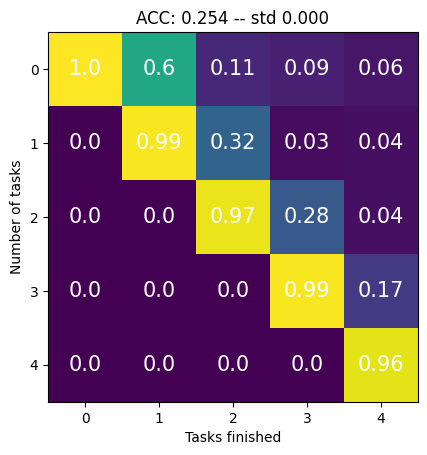

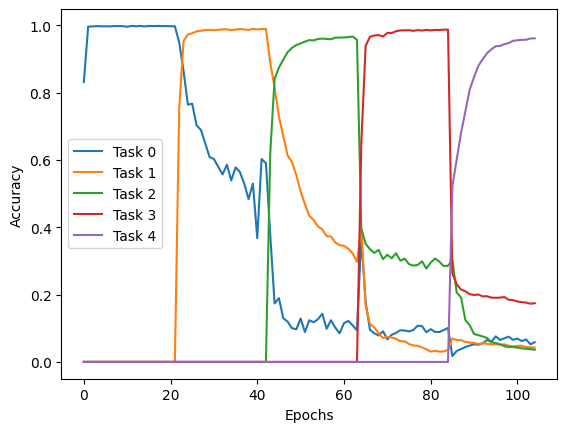

In [22]:
acc_at_end_arr = dict2array(agent.acc_end)
plot_accuracy_matrix(acc_at_end_arr)

acc_arr = dict2array(agent.acc)
plot_acc_over_time(acc_arr)

## Accuracy

In [23]:
print(f"The average accuracy at the end of sequence is: {compute_average_accuracy(acc_at_end_arr):.3f}")
print(f"BWT:'{compute_backward_transfer(acc_at_end_arr):.3f}'")
print(f"FWT:'{compute_forward_transfer(acc_at_end_arr, random_model_acc):.3f}'")

The average accuracy at the end of sequence is: 0.255
BWT:'-0.907'
FWT:'-0.048'


## Plots

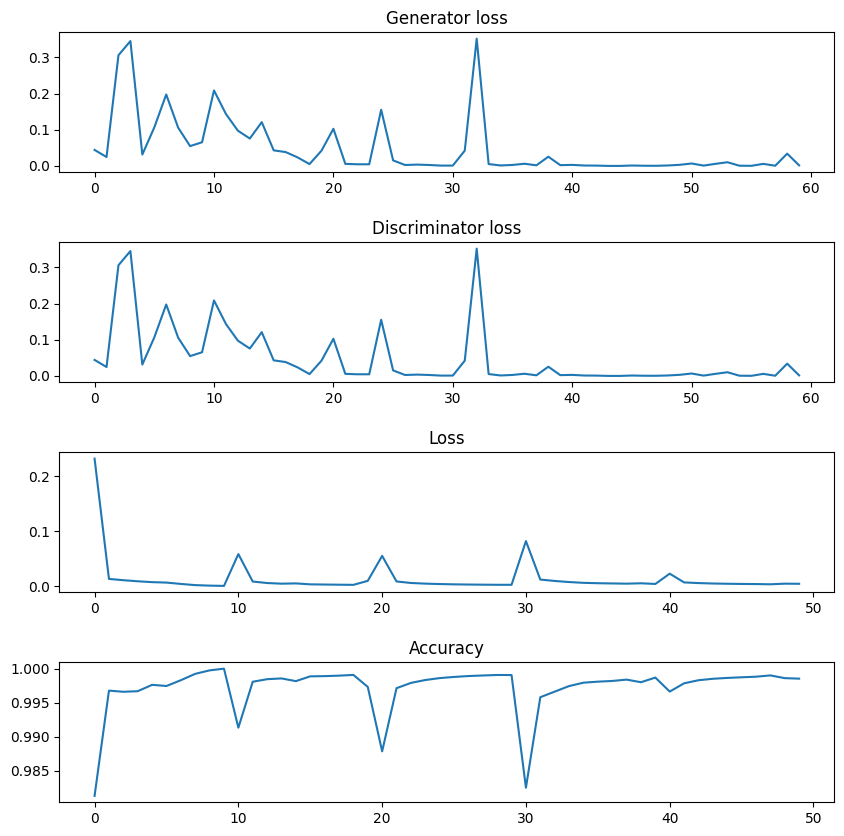

In [24]:
fig, axs = plt.subplots(len(results), figsize=(10, 10))
for i, (key, value) in enumerate(results.items()):
    axs[i].plot(value)
    axs[i].set_title(key)
fig.subplots_adjust(hspace=0.5)
